<a href="https://colab.research.google.com/github/alixintong/btt-ai-know-your-customer/blob/jess/bounding_box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this cell allows access to our folder

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_path = '/content/gdrive/MyDrive/BTTAI_AmericanExpress1'

Mounted at /content/drive


## For datasheet frames

In [ ]:
# cell for imports - add as needed
import torch 
import cv2
import numpy as np 
import pandas as pd
import os, os.path
import re
from fastai.vision.all import *

In [ ]:
# for reference
#   - fastai segmentation: https://walkwithfastai.com/Segmentation
#   - fastai object detection: https://walkwithfastai.com/Object_Detection

### Data

In [ ]:
path = '/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames'

files = get_image_files(path + "/datasheet001_frames")
len(files)

0

In [ ]:
# import bounding box datasheet csv
# use datasheet001 as csv instead of xml
url='https://drive.google.com/file/d/1lUoBf1rwPXPlI9Zg2lDzwV4ODtsGJ4u2/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,_rejected
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,False
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,False
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,False
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,False
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,False


In [ ]:
df["document"] = df["_rejected"].apply(lambda x: not x)

In [ ]:
df = df.drop('_rejected', axis = 1)
df.head()

,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,document
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,True
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,True
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,True
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,True
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,True


In [ ]:
def get_coordinates(row_data):
  x1 = min(row_data[1], row_data[4], row_data[7], row_data[10])
  y1 = min(row_data[2], row_data[5], row_data[8], row_data[11])
  x2 = max(row_data[1], row_data[4], row_data[7], row_data[10])
  y2 = max(row_data[2], row_data[5], row_data[8], row_data[11])
  bb_cd = [x1, y1, x2, y2] 
  return bb_cd

In [ ]:
bb = []
bb.append(df.apply(lambda row: get_coordinates(row), axis = 1))

In [ ]:
bb = np.array(bb)
bb = bb.flatten()

In [ ]:
bb = list(bb)

In [ ]:
df_bb = pd.DataFrame(data=bb, columns=['x1', 'y1', 'x2', 'y2'])

In [ ]:
df_bb.head()

,x1,y1,x2,y2
0,716.625,199.127,1259.02,805.609
1,714.326,200.028,1257.21,806.309
2,713.031,199.795,1255.42,804.811
3,713.845,196.852,1256.72,802.659
4,713.088,194.057,1259.35,802.830


In [ ]:
df_bb['document'] = df['document']
df_bb.head() # df_bb would be the labels of bounding boxes

,x1,y1,x2,y2,document
0,716.625,199.127,1259.02,805.609,True
1,714.326,200.028,1257.21,806.309,True
2,713.031,199.795,1255.42,804.811,True
3,713.845,196.852,1256.72,802.659,True
4,713.088,194.057,1259.35,802.830,True


In [ ]:
# get image names
os.chdir('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames')
imgs = os.listdir()

In [ ]:
bbox = []
for i in range(0,214):
  e = [list(df_bb.iloc[i,0:4]), [df_bb.iloc[i,4]]]
  bbox.append(e)

In [ ]:
# use a dictionary to quickly look up a corresponding image to it's label
img2bbox = dict(zip(imgs, bbox))

In [ ]:
# a getter function
getters = [lambda o: o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]] # o is the input image name

In [ ]:
# for transforms later
item_tfms = [Resize(128, method='pad')] 
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [ ]:
def get_train_imgs(noop): return imgs # simply return the images

In [ ]:
frames = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock), # define pre-defined problem domains: images, bb, label bb
                 splitter=RandomSplitter(), 
                 get_items=get_train_imgs, 
                 getters=getters, # getters applied to results of get_items
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [ ]:
frames.summary(os.getcwd())

In [ ]:
files = get_image_files(os.getcwd())

In [ ]:
files[:5]

(#5) [Path('/content/drive/.shortcut-targets-by-id/17C-FeV89lWfoxThc1mu8REz8adMDfNfP/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00001.jpg'),Path('/content/drive/.shortcut-targets-by-id/17C-FeV89lWfoxThc1mu8REz8adMDfNfP/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00002.jpg'),Path('/content/drive/.shortcut-targets-by-id/17C-FeV89lWfoxThc1mu8REz8adMDfNfP/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00003.jpg'),Path('/content/drive/.shortcut-targets-by-id/17C-FeV89lWfoxThc1mu8REz8adMDfNfP/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00004.jpg'),Path('/content/drive/.shortcut-targets-by-id/17C-FeV89lWfoxThc1mu8REz8adMDfNfP/BTTAI_AmericanExpress1/datasets/sampleDataset/frames/datasheet001_frames/datasheet001_frames_00005.jpg')]

In [ ]:
dls = frames.dataloaders(files)

In [ ]:
dls.c = 1

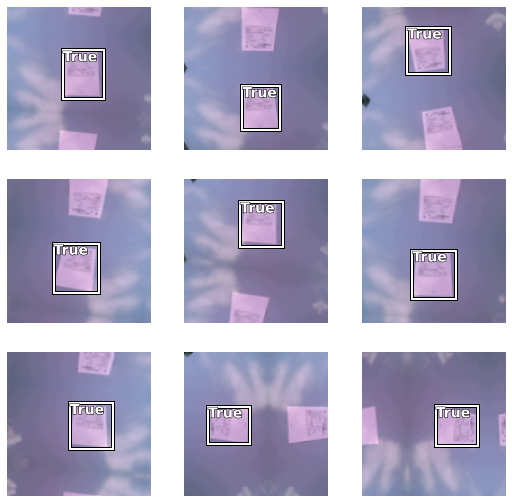

In [ ]:
dls.show_batch()

### Model

In [ ]:
!pip install wwf

In [ ]:
from wwf.vision.object_detection import * # use RetinaNet

In [ ]:
encoder = create_body(resnet34(), pretrained=True) # use transfer learning here by creating an encoder (body) of our model and a head

In [ ]:
get_c(dls)

1

In [ ]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

In [ ]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

We have one with a smoother, a classifer, and a box_regressor (to get our points)


In [ ]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

For RetinaNet to work, we need to define what the aspect ratio's and scales of our image should be.

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

### Loss Function

Our loss function

In [ ]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

Our learner

In [ ]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [ ]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [ ]:
learn.freeze()

Train

In [ ]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,3.670211,3.441589,00:15
1,3.480963,3.147752,00:11
2,2.943281,2.192409,00:16
3,2.694649,2.863556,00:12
4,2.508749,2.896998,00:11
5,2.376828,2.642549,00:11
6,2.220703,2.297852,00:11
7,2.073781,1.993115,00:12
8,1.986817,1.861703,00:12
9,1.913177,1.788226,00:11


## For the whole sample dataset

In [2]:
# cell for imports - add as needed
import torch 
import cv2
import numpy as np 
import pandas as pd
import os, os.path
import re
from fastai.vision.all import *

### Data

In [71]:
# get all frames with documents
files = get_image_files('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb/datasheet001_frames') 
files += get_image_files('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb/letter001_frames') 
files += get_image_files('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb/magazine001_frames') 
len(files)

588

In [6]:
# import bounding box datasheet csv
# use datasheet001 as csv instead of xml
url_ds ='https://drive.google.com/file/d/1lUoBf1rwPXPlI9Zg2lDzwV4ODtsGJ4u2/view?usp=sharing'
url_ds ='https://drive.google.com/uc?id=' + url_ds.split('/')[-2]
df_ds = pd.read_csv(url_ds)
print(df_ds.shape)
df_ds.head()

(214, 14)


,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,_rejected
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,False
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,False
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,False
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,False
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,False


In [7]:
# import bounding box letter csv
url_letter ='https://raw.githubusercontent.com/alixintong/btt-ai-know-your-customer/jess/csv_files/letter001.gt.csv'
df_letter = pd.read_csv(url_letter)
print(df_letter.shape)
df_letter.head()


(176, 14)


,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,_rejected
0,bl,703.838,821.867,tl,698.301,223.969,tr,1127.11,225.648,br,1216.89,799.264,1,False
1,bl,702.118,822.136,tl,696.436,224.119,tr,1125.88,226.403,br,1215.78,800.164,2,False
2,bl,701.706,823.286,tl,696.182,225.742,tr,1124.90,227.576,br,1215.36,801.663,3,False
3,bl,702.937,823.223,tl,697.259,226.687,tr,1125.50,229.178,br,1215.80,801.339,4,False
4,bl,703.555,821.741,tl,698.101,225.573,tr,1126.22,228.164,br,1216.56,800.871,5,False


In [8]:
# import bounding box magazine csv
url_mg ='https://raw.githubusercontent.com/alixintong/btt-ai-know-your-customer/jess/csv_files/magazine001.gt.csv'
df_mg = pd.read_csv(url_mg)
print(df_mg.shape)
df_mg.head()

(198, 14)


,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,_rejected
0,bl,643.369,788.654,tl,725.440,286.566,tr,1111.97,248.837,br,1117.02,771.367,1,False
1,bl,646.817,786.206,tl,727.790,283.995,tr,1114.79,246.905,br,1119.57,769.517,2,False
2,bl,649.980,785.877,tl,731.489,283.129,tr,1117.30,246.603,br,1121.99,769.330,3,False
3,bl,648.455,786.756,tl,731.316,284.050,tr,1117.17,247.518,br,1120.94,770.220,4,False
4,bl,645.193,785.709,tl,727.231,283.242,tr,1114.96,247.235,br,1119.62,768.734,5,False


In [9]:
# merge the three dataframes
#   datasheet + letter + magazine
df = pd.concat([df_ds, df_letter])
df = pd.concat([df, df_mg])
print(df.shape)
df.head()

(588, 14)


,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,_rejected
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,False
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,False
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,False
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,False
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,False


In [10]:
df["document"] = df["_rejected"].apply(lambda x: not x)
df = df.drop('_rejected', axis = 1)
df.head()

,point/0/_name,point/0/_x,point/0/_y,point/1/_name,point/1/_x,point/1/_y,point/2/_name,point/2/_x,point/2/_y,point/3/_name,point/3/_x,point/3/_y,_index,document
0,bl,716.625,805.609,tl,737.377,201.383,tr,1180.71,199.127,br,1259.02,791.942,1,True
1,bl,714.326,806.309,tl,736.330,202.300,tr,1179.74,200.028,br,1257.21,792.161,2,True
2,bl,713.031,804.811,tl,734.431,201.449,tr,1177.81,199.795,br,1255.42,791.291,3,True
3,bl,713.845,802.659,tl,734.423,198.474,tr,1177.79,196.852,br,1256.72,789.631,4,True
4,bl,713.088,802.830,tl,734.675,195.678,tr,1179.99,194.057,br,1259.35,790.289,5,True


In [11]:
def get_coordinates(row_data):
  x1 = min(row_data[1], row_data[4], row_data[7], row_data[10])
  y1 = min(row_data[2], row_data[5], row_data[8], row_data[11])
  x2 = max(row_data[1], row_data[4], row_data[7], row_data[10])
  y2 = max(row_data[2], row_data[5], row_data[8], row_data[11])
  bb_cd = [x1, y1, x2, y2] 
  return bb_cd

In [12]:
bb = []
bb.append(df.apply(lambda row: get_coordinates(row), axis = 1))

bb = np.array(bb)
bb = bb.flatten()
bb = list(bb)

In [13]:
df_bb = pd.DataFrame(data=bb, columns=['x1', 'y1', 'x2', 'y2'])
df_bb.head()

,x1,y1,x2,y2
0,716.625,199.127,1259.02,805.609
1,714.326,200.028,1257.21,806.309
2,713.031,199.795,1255.42,804.811
3,713.845,196.852,1256.72,802.659
4,713.088,194.057,1259.35,802.830


In [14]:
df_bb['document'] = list(df['document'])
df_bb.head() # df_bb would be the labels of bounding boxes

,x1,y1,x2,y2,document
0,716.625,199.127,1259.02,805.609,True
1,714.326,200.028,1257.21,806.309,True
2,713.031,199.795,1255.42,804.811,True
3,713.845,196.852,1256.72,802.659,True
4,713.088,194.057,1259.35,802.830,True


In [15]:
# get image names
#   datasheet + letter + magazine (need to be in this order!)
os.chdir('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb/datasheet001_frames')
imgs = os.listdir()
os.chdir('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb/letter001_frames')
imgs += os.listdir()
os.chdir('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb/magazine001_frames')
imgs += os.listdir()

In [47]:
imgs

['datasheet001_frames_00001.jpg',
 'datasheet001_frames_00002.jpg',
 'datasheet001_frames_00003.jpg',
 'datasheet001_frames_00004.jpg',
 'datasheet001_frames_00005.jpg',
 'datasheet001_frames_00006.jpg',
 'datasheet001_frames_00007.jpg',
 'datasheet001_frames_00008.jpg',
 'datasheet001_frames_00009.jpg',
 'datasheet001_frames_00010.jpg',
 'datasheet001_frames_00011.jpg',
 'datasheet001_frames_00012.jpg',
 'datasheet001_frames_00013.jpg',
 'datasheet001_frames_00014.jpg',
 'datasheet001_frames_00015.jpg',
 'datasheet001_frames_00016.jpg',
 'datasheet001_frames_00017.jpg',
 'datasheet001_frames_00018.jpg',
 'datasheet001_frames_00019.jpg',
 'datasheet001_frames_00020.jpg',
 'datasheet001_frames_00021.jpg',
 'datasheet001_frames_00022.jpg',
 'datasheet001_frames_00023.jpg',
 'datasheet001_frames_00024.jpg',
 'datasheet001_frames_00025.jpg',
 'datasheet001_frames_00026.jpg',
 'datasheet001_frames_00027.jpg',
 'datasheet001_frames_00028.jpg',
 'datasheet001_frames_00029.jpg',
 'datasheet001

In [18]:
len(imgs)

588

In [61]:
bbox = []
for i in range(0,len(imgs)):
  e = [list(df_bb.iloc[i,0:4]), [df_bb.iloc[i,4]]]
  bbox.append(e)

In [62]:
# use a dictionary to quickly look up a corresponding image to it's label
img2bbox = dict(zip(imgs, bbox))
#img2bbox

In [63]:
# check the first item
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'datasheet001_frames_00001.jpg': [[716.625, 199.127, 1259.02, 805.609],
  [True]]}

In [64]:
# a getter function
#   o is the input image name
#   img2bbox[o][0]: the coordinates
#   img2bbox[o][1]: the label 'True' / 'False'
getters = [lambda o: o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]] 

In [65]:
# for transforms later
item_tfms = [Resize(128, method='pad')] 
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [66]:
def get_train_imgs(noop): return imgs # simply return the images

In [67]:
frames = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock), # define pre-defined problem domains: images, bb, label bb
                 splitter=RandomSplitter(), 
                 get_items=get_train_imgs, 
                 getters=getters, # getters applied to results of get_items
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [68]:
os.chdir('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb')

In [69]:
frames.summary(os.getcwd()) 

Setting-up type transforms pipelines
Found 588 items
2 datasets of sizes 471,117
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> TensorBBox.create
Setting up Pipeline: <lambda> -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      magazine001_frames_00188.jpg
    applying <lambda> gives
      magazine001_frames_00188.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1920x1080
  Pipeline: <lambda> -> TensorBBox.create
    starting from
      magazine001_frames_00188.jpg
    applying <lambda> gives
      [873.797, 281.266, 1325.25, 791.247]
    applying TensorBBox.create gives
      TensorBBox of size 1x4
  Pipeline: <lambda> -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}
    starting from
      magazine001_frames_00188.jpg
    applying <lambda> gives
      [True]
    applying MultiCategorize -- {'vocab': None, 'sort': Tr

In [72]:
files[:5]

(#5) [Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb/datasheet001_frames/datasheet001_frames_00001.jpg'),Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb/datasheet001_frames/datasheet001_frames_00002.jpg'),Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb/datasheet001_frames/datasheet001_frames_00003.jpg'),Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb/datasheet001_frames/datasheet001_frames_00004.jpg'),Path('/content/drive/MyDrive/BTTAI_AmericanExpress1/datasets/sampleDataset/frames_bb/datasheet001_frames/datasheet001_frames_00005.jpg')]

In [73]:
dls = frames.dataloaders(files)

In [74]:
dls.c = 1

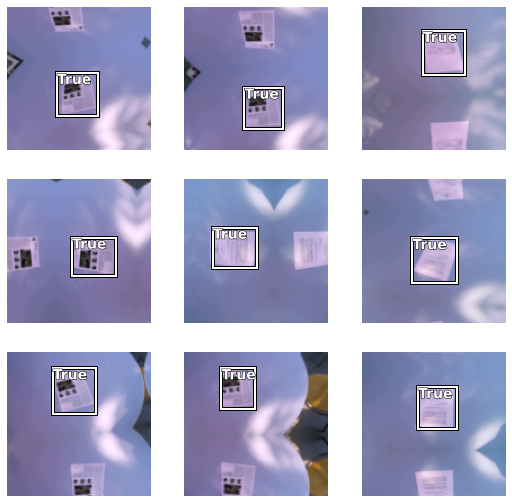

In [75]:
dls.show_batch()

### Model

In [ ]:
!pip install wwf

In [77]:
from wwf.vision.object_detection import * # use RetinaNet

In [78]:
encoder = create_body(resnet34(), pretrained=True) # use transfer learning here by creating an encoder (body) of our model and a head

In [79]:
get_c(dls)

1

In [80]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

In [81]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

We have one with a smoother, a classifer, and a box_regressor (to get our points)


In [82]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [83]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [84]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

For RetinaNet to work, we need to define what the aspect ratio's and scales of our image should be.

In [85]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

### Loss Function

Our loss function

In [86]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

Our learner

In [87]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [88]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [89]:
learn.freeze()

Train

In [90]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,3.454025,3.301009,00:32
1,2.830742,2.703547,00:29
2,2.350417,1.737624,00:29
3,1.990814,1.056583,00:29
4,1.737839,0.890901,00:31
5,1.543903,0.797465,00:29
6,1.394089,0.724146,00:29
7,1.280798,0.684034,00:29
8,1.195544,0.678414,00:29
9,1.124046,0.685245,00:31
